Reference video: 
https://www.youtube.com/watch?v=o2NMWV5sImM&list=PL58zEckBH8fBW_XLPtIPlQ-mkSNNx0tLS&index=8

In [1]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

### Training with Q Table

In [2]:
def pendulum(name, is_training=True, render=False):
    env = gym.make(
        'Pendulum-v1', 
        render_mode='human' if render else None
    )
    
    # Divide obversion space into segments
    divisions = 15
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    
    # Divide action space into segments
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    # Define Q Table
    if is_training:
        q = np.zeros((
            len(x) + 1, 
            len(y) + 1, 
            len(w) + 1, 
            len(a) + 1
        ))
    else:
        f = open(f'q_tables/q_{name}.pkl', 'rb')
        q = pkl.load(f)
        f.close()
    
    # Define the hyperparameters
    learning_rate_a = 0.1   # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor
    
    # Define policy parameters: we use the Epsilon Greedy Algorithm
    epsilon = 1                         # 1 = 100% random actions
    epsilon_decay_rate = 0.0005         # decay rate of epsilon
    epsilon_min = 0.05
    rng = np.random.default_rng()       # random number generator
    
    # Keep track of the rewards per episode
    best_reward = -999999
    rewards_per_episode = []
    
    # Keep track of the episodes
    i = 0
    
    # Iterate through all episodes
    while (True):
        state = env.reset()[0]  
        s_x = np.digitize(state[0], x)
        s_y = np.digitize(state[1], y)
        s_w = np.digitize(state[2], w)
        rewards = 0             # Rewards collected per episode
        steps = 0
        
        while(steps < 1000 or is_training == False):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
                action_idx = np.digitize(action, a)
            else:
                action_idx = np.argmax(q[s_x, s_y, s_w, :])
                action = a[action_idx - 1]
            
            new_state, reward, _, _, _ = env.step([action])
            
            # Digitize the new states
            ns_x = np.digitize(new_state[0], x)
            ns_y = np.digitize(new_state[1], y)
            ns_w = np.digitize(new_state[2], w)
            
            # Apply the Q Learning formula after taking a step
            if is_training:
                q[s_x, s_y, s_w, action_idx] = q[s_x, s_y, s_w, action_idx] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[ns_x, ns_y, ns_w, :]) - q[s_x, s_y, s_w, action_idx]
                )
            
            state = new_state
            s_x = ns_x
            s_y = ns_y
            s_w = ns_w
            rewards += reward
            steps += 1
            
        if not is_training and rewards%100 == 0:
            print(f'Accumulated rewards: {rewards}')
        
        if is_training and rewards > best_reward:
            best_reward = rewards
            
            # Save the Q Table
            f = open(f'q_tables/q_{name}.pkl', 'wb')
            pkl.dump(q, f)
            f.close()  
        
        # Append rewards per episode and calculate mean reward for last 100 episodes
        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
        
        # Print some information every 100 episodes
        if is_training and i%100 == 0:
            print(f'Episode {i} rewards: {rewards}, Epsilon: {epsilon:0.2f}, Mean Rewards: {mean_rewards:0.1f}')
        
        # Stop training
        if best_reward > -500:
            print(f'Best reward: {best_reward}')
            break
        
        # Decrease epsilon after each episode until it reaches 0
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)  
        
        # Update i to keep track of the episode number
        i += 1
    
    # Close the environment
    env.close()
    
    # Plot the rewards per episode graph
    if render == False:
        mean_rewards = []
        for t in range(i):
            mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
        plt.xlabel('Iterations')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)
    
    if is_training:
        print('Training completed!')

In [3]:
name = 'pendulum'

/home/evanch317/miniconda3/envs/env_rl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/evanch317/miniconda3/envs/env_rl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


Episode 0 rewards: [-5098.94680032], Epsilon: 1.00, Mean Rewards: -5098.9
Episode 100 rewards: [-5393.77440418], Epsilon: 0.95, Mean Rewards: -6154.4
Episode 200 rewards: [-4760.5475291], Epsilon: 0.90, Mean Rewards: -6046.5
Episode 300 rewards: [-4805.7488563], Epsilon: 0.85, Mean Rewards: -5882.0
Episode 400 rewards: [-4624.08384107], Epsilon: 0.80, Mean Rewards: -5915.5
Episode 500 rewards: [-5608.39590375], Epsilon: 0.75, Mean Rewards: -5790.4
Episode 600 rewards: [-4649.10325086], Epsilon: 0.70, Mean Rewards: -5560.8
Episode 700 rewards: [-4392.32981355], Epsilon: 0.65, Mean Rewards: -5449.1
Episode 800 rewards: [-4526.50693142], Epsilon: 0.60, Mean Rewards: -5274.3
Episode 900 rewards: [-5491.20444603], Epsilon: 0.55, Mean Rewards: -5168.8
Episode 1000 rewards: [-3260.29767136], Epsilon: 0.50, Mean Rewards: -4972.6
Episode 1100 rewards: [-3196.75406816], Epsilon: 0.45, Mean Rewards: -4605.5
Episode 1200 rewards: [-2922.23382641], Epsilon: 0.40, Mean Rewards: -3937.1
Episode 1300 

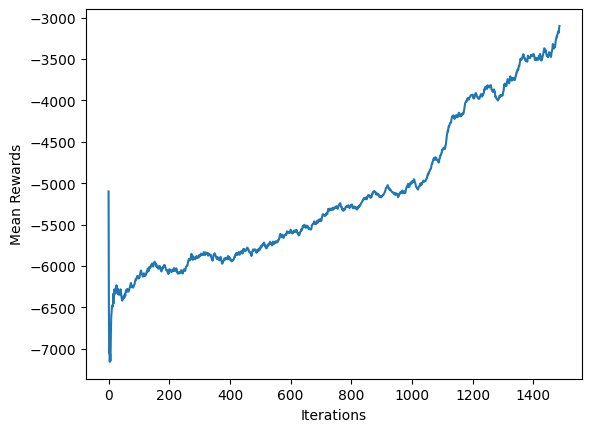

In [ ]:
# Train
pendulum(name)

In [ ]:
# Watch the trained agent
pendulum(name, is_training=False, render=True)